<a href="https://colab.research.google.com/github/ShinHeeEul/sesequiz/blob/main/DataGenerator/Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 폰트 설정을 위한 코드
!apt-get update -qq
!apt-get install fonts-nanum* -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123595 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

In [ ]:
import gc
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split

import warnings
import albumentations as albu
warnings.filterwarnings('ignore')

## GPU Settings
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_MODELS_FROM = None

from google.colab import drive
import zipfile

tensorflow version:  2.17.0
Using 0 GPUs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Food Images/Kfood"

big_category = ['구이', '국', '기타', '김치', '나물', '면']
df_list = []

for category in big_category:
    extract_dir = os.path.join(base_path, category)

    csv_files = glob(os.path.join(extract_dir, "**/*.csv"), recursive=True)

    for csv_file in csv_files:
        food = os.path.basename(os.path.dirname(csv_file))
        kf_df = pd.read_csv(csv_file, header=None, names=['filename', 'url', 'tmp'])
        kf_df['food_category'] = category
        kf_df['food_name'] = food
        kf_df['image_path'] = kf_df['filename'].apply(lambda x: os.path.join(os.path.dirname(csv_file), x))
        df_list.append(kf_df)

df = pd.concat(df_list, ignore_index=True)
df = df[df['image_path'].apply(os.path.exists)]
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,filename,url,tmp,food_category,food_name,image_path
0,Img_012_0000.jpg,http://img.dongwonmall.com/dwmall/static_root/...,NaN,구이,황태구이,/content/drive/MyDrive/Food Images/Kfood/구이/구...
1,Img_012_0002.JPG,http://postfiles3.naver.net/20140905_210/ridia...,NaN,구이,황태구이,/content/drive/MyDrive/Food Images/Kfood/구이/구...
2,Img_012_0003.JPG,http://postfiles16.naver.net/20130208_287/smy2...,NaN,구이,황태구이,/content/drive/MyDrive/Food Images/Kfood/구이/구...
3,Img_012_0004.jpg,http://cfile205.uf.daum.net/image/114587404D2F...,NaN,구이,황태구이,/content/drive/MyDrive/Food Images/Kfood/구이/구...
4,Img_012_0005.jpg,http://cfile235.uf.daum.net/image/115FCF344F65...,NaN,구이,황태구이,/content/drive/MyDrive/Food Images/Kfood/구이/구...


In [ ]:
print("DataFrame 샘플:")
print(f"총 이미지 수: {len(df)}")
print(f"음식 카테고리 수: {df['food_category'].nunique()}")
print(f"음식 종류 수: {df['food_name'].nunique()}")

print("\n음식별 이미지 수:")
print(df['food_name'].value_counts())

DataFrame 샘플:
총 이미지 수: 11687
음식 카테고리 수: 4
음식 종류 수: 33

음식별 이미지 수:
food_name
불고기            648
칼국수           549
삼겹살          495
떡국_만두국    480
닭갈비           480
물냉면          447
떡갈비           441
콩나물국        384
미역국           384
오이소박이        371
고등어구이        370
장어구이          368
열무국수         368
열무김치         366
북엇국          361
배추김치          341
막국수           336
무국              334
총각김치        314
갈치구이          314
부추김치          297
파김치            294
시래기국          293
황태구이          291
계란국           290
깍두기            288
나박김치         273
더덕구이          270
육개장           267
무생채            261
갈비구이          241
갓김치           236
훈제오리          235
Name: count, dtype: int64


In [ ]:
df = df.drop(['url','tmp'],axis=1)
df.head()

,filename,food_category,food_name,image_path
0,Img_012_0000.jpg,구이,황태구이,/content/drive/MyDrive/Food Images/Kfood/구이/구...
1,Img_012_0002.JPG,구이,황태구이,/content/drive/MyDrive/Food Images/Kfood/구이/구...
2,Img_012_0003.JPG,구이,황태구이,/content/drive/MyDrive/Food Images/Kfood/구이/구...
3,Img_012_0004.jpg,구이,황태구이,/content/drive/MyDrive/Food Images/Kfood/구이/구...
4,Img_012_0005.jpg,구이,황태구이,/content/drive/MyDrive/Food Images/Kfood/구이/구...


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
TARGET = list(df['food_name'].unique())
TARGET
len(TARGET)

33

In [ ]:
for col in df['food_name'].unique():
    df_test[col] = np.where(df_test['food_name'].str.contains(col), 1.0, 0.0).astype('float32')
    df_train[col] = np.where(df_train['food_name'].str.contains(col), 1.0, 0.0).astype('float32')

In [ ]:
label_counts = df['food_name'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(label_counts, labels=list(label_counts.index), autopct='%.1f%%')
ax1.set_title('음식 종류별 비율')

ax2.bar(list(label_counts.index), label_counts.values)
ax2.set_title('막대 그래프')
ax2.set_xlabel('음식 이름')
ax2.set_ylabel('개수')
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, preprocess=None, target_col='food_name', **kwargs):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.preprocess = preprocess
        self.target_col = target_col
        self.augmentation_settings = kwargs
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        X = self.__apply_augmentations(X)

        # preprocess가 설정된 경우만 적용
        if self.preprocess is not None:
            X = self.preprocess(X)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.zeros((len(indexes), 256, 256, 3), dtype='float32')
        y = np.zeros((len(indexes),), dtype='object')  # 타겟을 문자열로 저장

        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['image_path']
            img = Image.open(path).convert('RGB')
            img = img.resize((256, 256), Image.Resampling.LANCZOS)
            img = np.array(img)

            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            X[j, :, :] = img
            y[j] = row[self.target_col]

        return X, y

    def __apply_augmentations(self, img_batch):
        if self.augmentation_settings.get('resize', False):
            img_batch = self.__resize(img_batch)
        if self.augmentation_settings.get('rotate', False):
            img_batch = self.__rotate(img_batch)
        if self.augmentation_settings.get('zoom', False):
            img_batch = self.__zoom(img_batch)
        if self.augmentation_settings.get('warp', False):
            img_batch = self.__warp(img_batch)
        if self.augmentation_settings.get('lighting', False):
            img_batch = self.__lighting(img_batch)
        if self.augmentation_settings.get('flip', False):
            img_batch = self.__flip(img_batch)
        if self.augmentation_settings.get('erasing', False):
            img_batch = self.__erasing(img_batch)
        if self.augmentation_settings.get('normalize', False) and self.preprocess is None:
            img_batch = self.__normalize(img_batch)
        if self.augmentation_settings.get('mixup', False):
            img_batch = self.__mixup(img_batch)
        return img_batch

    def __resize(self, img_batch):
        target_size = self.augmentation_settings.get('resize_target', (320, 320))
        composition = albu.Compose([
            albu.Resize(height=target_size[0], width=target_size[1], always_apply=True),
            albu.Resize(height=256, width=256, always_apply=True),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __rotate(self, img_batch):
        limit = self.augmentation_settings.get('rotate_limit', 20)
        prob = self.augmentation_settings.get('rotate_prob', 0.75)
        composition = albu.Compose([
            albu.Rotate(limit=limit, p=prob),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __zoom(self, img_batch):
        scale = self.augmentation_settings.get('zoom_scale', (0.8, 1.2))
        prob = self.augmentation_settings.get('zoom_prob', 0.75)
        composition = albu.Compose([
            albu.RandomScale(scale_limit=(scale[0]-1, scale[1]-1), p=prob),
            albu.Resize(height=256, width=256, always_apply=True),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __warp(self, img_batch):
        alpha = self.augmentation_settings.get('warp_alpha', 100)
        sigma = self.augmentation_settings.get('warp_sigma', 10)
        prob = self.augmentation_settings.get('warp_prob', 0.75)
        composition = albu.Compose([
            albu.ElasticTransform(alpha=alpha, sigma=sigma, alpha_affine=None, p=prob),  # Set alpha_affine to None
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __lighting(self, img_batch):
        brightness = self.augmentation_settings.get('brightness_limit', 0.2)
        contrast = self.augmentation_settings.get('contrast_limit', 0.2)
        prob = self.augmentation_settings.get('lighting_prob', 0.75)
        composition = albu.Compose([
            albu.RandomBrightnessContrast(brightness_limit=brightness, contrast_limit=contrast, p=prob),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __flip(self, img_batch):
        prob = self.augmentation_settings.get('flip_prob', 0.5)
        composition = albu.Compose([
            albu.HorizontalFlip(p=prob),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __erasing(self, img_batch):
        max_holes = self.augmentation_settings.get('erasing_max_holes', 8)
        max_height = self.augmentation_settings.get('erasing_max_height', 8)
        max_width = self.augmentation_settings.get('erasing_max_width', 8)
        prob = self.augmentation_settings.get('erasing_prob', 0.5)
        composition = albu.Compose([
            albu.CoarseDropout(max_holes=max_holes, max_height=max_height, max_width=max_width, p=prob),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __normalize(self, img_batch):
        mean = self.augmentation_settings.get('normalize_mean', (0.485, 0.456, 0.406))
        std = self.augmentation_settings.get('normalize_std', (0.229, 0.224, 0.225))
        composition = albu.Compose([
            albu.Normalize(mean=mean, std=std, always_apply=True),
        ])
        return self.__apply_augmentation(img_batch, composition)

    def __mixup(self, img_batch):
        alpha = self.augmentation_settings.get('mixup_alpha', 0.2)
        prob = self.augmentation_settings.get('mixup_prob', 0.1)
        if np.random.rand() > prob:
            return img_batch

        batch_size = img_batch.shape[0]
        lam = np.random.beta(alpha, alpha, batch_size)
        lam = np.max([lam, 1-lam], axis=0)
        index = np.random.permutation(batch_size)

        lam = lam.reshape(batch_size, 1, 1, 1)
        mixed_img_batch = lam * img_batch + (1 - lam) * img_batch[index]
        return mixed_img_batch

    def __apply_augmentation(self, img_batch, composition):
        for i in range(img_batch.shape[0]):
            img_batch[i] = composition(image=img_batch[i])['image']
        return img_batch


In [ ]:
!pip install -q git+https://github.com/qubvel/classification_models.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


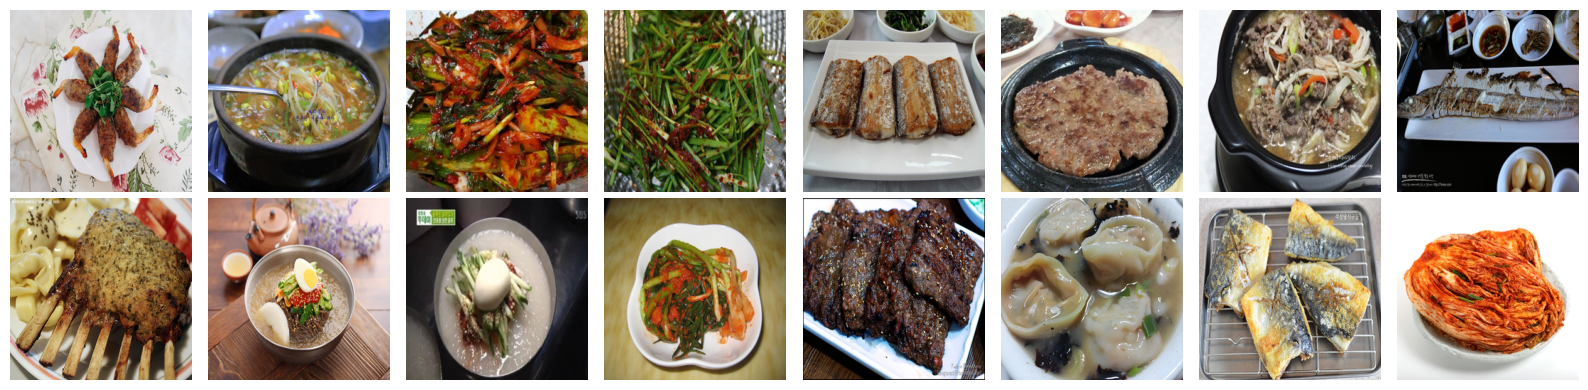

In [ ]:
from classification_models.tfkeras import Classifiers

# ResNet18 모델과 전처리 함수 가져오기
resnet18, preprocess_input = Classifiers.get('resnet18')

ROWS,COLS = 2,8

gen = DataGenerator(df_train, batch_size=ROWS * COLS, shuffle=False, preprocess=None)

for i, (x, y) in enumerate(gen):
    plt.figure(figsize=(COLS * 2, ROWS * 2))

    for j in range(x.shape[0]):
        plt.subplot(ROWS, COLS, j + 1)

        img = x[j, :, :, :3]
        plt.imshow(img.astype('uint8'))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    if i == 0: break